MH

Train neural network models (at least two different networks for each dataset, i.e., no. layers, no. neurons, activation, ...) in either Tensorflow or Pytorch to perform classification on the following datasets:

Cifar-100

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
 
import numpy as np
import PIL
import matplotlib.pyplot as mtplt
 
print("imported!")

imported!


Import data:

Download and extract the data, then rename to cifar-10:

In [2]:
 torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True)

Extracting ./data/cifar-100-python.tar.gz to ./data


Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

Create a dataset with manual import using pickle's unpickle:

In [3]:
from PIL import Image
import os
import os.path
import numpy as np
import pickle
from typing import Any, Callable, Optional, Tuple
 
class CIFAR100(torchvision.datasets.vision.VisionDataset):
    base_folder = 'cifar-100'
    train_list = [
        'train',
    ]
 
    test_list = [
        'test',
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'key2': 'coarse_label_names'
    }
 
    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None
    ) -> None:
 
        super(CIFAR100, self).__init__(root, transform=transform,
                                      target_transform=target_transform)
 
        self.train = train  # training set or test set
 
        if self.train:
            the_list = self.train_list
        else:
            the_list = self.test_list
 
        self.data: Any = []
        self.targets = []
 
        # now load the picked numpy arrays
        for file_name in the_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            import pickle
            with open(file_path, 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                if 'fine_labels' in entry:
                    self.targets.extend(entry['fine_labels'])
 
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC
 
        self._load_meta()
 
    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])
        import pickle
        with open(path, 'rb') as infile:
            data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['key']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}
 
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]
 
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)
 
        if self.transform is not None:
            img = self.transform(img)
 
        if self.target_transform is not None:
            target = self.target_transform(target)
 
        return img, target
 
    def __len__(self) -> int:
        return len(self.data)
 
    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")

Load training and test set and loaders using the previous custom dataset, then applying a normalization transform with mean and std of 0.5 for 3 channels:

In [4]:
transf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 
train_set = CIFAR100(root='./data', train=True, transform=transf)
test_set = CIFAR100(root='./data', train=False, transform=transf)
 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                         shuffle=False, num_workers=2)
 
train_set._load_meta()
classes = train_set.classes

Show some images:

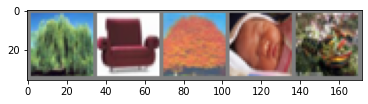

classes:  willow_tree couch maple_tree  baby lobster


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    mtplt.imshow(np.transpose(npimg, (1, 2, 0)))
    mtplt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:5]))

print('classes: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))

Define two networks, one using a simple multi-layer fully-connected network and one using convolutional layers (CNN):

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(64 * 6 * 6, 196)
        self.fc2 = nn.Linear(196, 128)
        self.out = nn.Linear(128, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.out(x)
        return x


net = Net()

In [7]:
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.linear1 = nn.Linear(3*32*32, 3072)
        self.linear2 = nn.Linear(3072, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.linear4 = nn.Linear(512, 256)
        self.linear5 = nn.Linear(256, 100)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out
net2 = Net2()

Define a Loss function and optimizer

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
import torch.optim as optim

criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(net2.parameters(), lr=0.0015, momentum=0.8)

Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
# Assuming that we are on a CUDA machine, this should print a CUDA device:
 
print(device)

cuda:0


In [11]:
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten()
  (fc1): Linear(in_features=2304, out_features=196, bias=True)
  (fc2): Linear(in_features=196, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=100, bias=True)
)

In [12]:
from torch.autograd import Variable

epochs=30

# for later visualiztions:
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        
        # Testing the model
        if not (i % 50):
            total = 0
            correct = 0
        
            for images, label in test_loader:
                images, label = images.to(device), label.to(device)
            
                # test = Variable(images.view(16, 3, 32, 32))
                test = images
            
                output = net(test)
            
                predictions = torch.max(output, 1)[1].to(device)
                correct += (predictions == label).sum()
            
                total += len(label)
            
            accuracy = (correct * 100.0) / total
            loss_list.append(loss.data)
            iteration_list.append(i)
            accuracy_list.append(accuracy)

        # print statistics
        running_loss += loss.item()
        if not (i % 100):    # print every 100 mini-batches
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / 100))
            running_loss = 0.0
            
            print("Epoch: {}, Step: {}, Loss: {}, Accuracy: {} %"
              .format(epoch + 1, i, loss.data, accuracy)
            )

print('Finished Training')

[1,     0] loss: 0.046
Epoch: 1, Step: 0, Loss: 4.6142964363098145, Accuracy: 1.0099999904632568 %
[1,   100] loss: 4.608
Epoch: 1, Step: 100, Loss: 4.602290630340576, Accuracy: 1.0099999904632568 %
[1,   200] loss: 4.605
Epoch: 1, Step: 200, Loss: 4.608185768127441, Accuracy: 0.9699999690055847 %
[1,   300] loss: 4.606
Epoch: 1, Step: 300, Loss: 4.604353427886963, Accuracy: 1.0199999809265137 %
[1,   400] loss: 4.604
Epoch: 1, Step: 400, Loss: 4.604758262634277, Accuracy: 1.1399999856948853 %
[1,   500] loss: 4.605
Epoch: 1, Step: 500, Loss: 4.602938175201416, Accuracy: 1.059999942779541 %
[1,   600] loss: 4.602
Epoch: 1, Step: 600, Loss: 4.598315715789795, Accuracy: 1.3399999141693115 %
[1,   700] loss: 4.603
Epoch: 1, Step: 700, Loss: 4.598538875579834, Accuracy: 1.5099999904632568 %
[2,     0] loss: 0.046
Epoch: 2, Step: 0, Loss: 4.602548122406006, Accuracy: 1.7999999523162842 %
[2,   100] loss: 4.599
Epoch: 2, Step: 100, Loss: 4.594335556030273, Accuracy: 1.7299998998641968 %
[2, 

In [13]:
net2.to(device)

Net2(
  (linear1): Linear(in_features=3072, out_features=3072, bias=True)
  (linear2): Linear(in_features=3072, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=100, bias=True)
)

In [14]:
from torch.autograd import Variable

# for later visualiztions:
loss_list2 = []
iteration_list2 = []
accuracy_list2 = []


for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        # inputs, labels = data[0], data[1]
        inputs, labels = data[0].to(device), data[1].to(device)
 
        # zero the parameter gradients
        optimizer2.zero_grad()
 
        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()
 
        
        # Testing the model
        if not (i % 50):
            total = 0
            correct = 0
        
            for images, label in test_loader:
                images, label = images.to(device), label.to(device)
            
                # test = Variable(images.view(4, 3, 32, 32))
                test = images
            
                output = net2(test)
            
                predictions = torch.max(output, 1)[1].to(device)
                correct += (predictions == label).sum()
            
                total += len(label)
            
            accuracy = (correct * 100.0) // total
            loss_list2.append(loss.data)
            iteration_list2.append(i)
            accuracy_list2.append(accuracy)

        # print statistics
        running_loss += loss.item()
        if not (i % 100):    # print every 100 mini-batches
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            
            print("Epoch: {}, Step: {}, Loss: {}, Accuracy: {}%"
              .format(epoch + 1, i, loss.data, accuracy)
            )

print('Finished Training')

[1,     1] loss: 0.046
Epoch: 1, Step: 0, Loss: 4.606952667236328, Accuracy: 0%
[1,   101] loss: 4.606
Epoch: 1, Step: 100, Loss: 4.603621006011963, Accuracy: 0%
[1,   201] loss: 4.605
Epoch: 1, Step: 200, Loss: 4.599776268005371, Accuracy: 0%
[1,   301] loss: 4.604
Epoch: 1, Step: 300, Loss: 4.603903293609619, Accuracy: 0%
[1,   401] loss: 4.603
Epoch: 1, Step: 400, Loss: 4.609135150909424, Accuracy: 0%
[1,   501] loss: 4.603
Epoch: 1, Step: 500, Loss: 4.599764347076416, Accuracy: 1%
[1,   601] loss: 4.602
Epoch: 1, Step: 600, Loss: 4.603945732116699, Accuracy: 1%
[1,   701] loss: 4.602
Epoch: 1, Step: 700, Loss: 4.599098205566406, Accuracy: 1%
[2,     1] loss: 0.046
Epoch: 2, Step: 0, Loss: 4.594235420227051, Accuracy: 2%
[2,   101] loss: 4.600
Epoch: 2, Step: 100, Loss: 4.60037899017334, Accuracy: 2%
[2,   201] loss: 4.599
Epoch: 2, Step: 200, Loss: 4.607909202575684, Accuracy: 2%
[2,   301] loss: 4.598
Epoch: 2, Step: 300, Loss: 4.606227874755859, Accuracy: 2%
[2,   401] loss: 4.59

Let's save our models:

In [15]:
path1 = './cifar1.pth'
path2 = './cifar2.pth'
torch.save(net.state_dict(), path1)
torch.save(net2.state_dict(), path2)

 Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the real values. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

Test Network_1 (CNN):

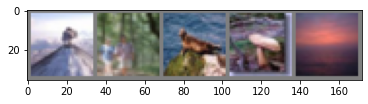

Real values:  mountain forest  seal mushroom   sea


In [16]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[0:5]))
print('Real values: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [17]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:  rocket leopard palm_tree skunk   sea


The second net (simple fully connected):

In [19]:
outputs2 = net2(images.to(device))
_, predicted2 = torch.max(outputs2, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted2[j]]
                              for j in range(5)))

Predicted:  bridge crocodile camel  bowl   sea


Hmmm. the second image do look like a car or truck..

Let's do some evaluations:

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100.0 * correct / total))

Accuracy of the network on the 10000 test images: 30 %


And for the second net:

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100.0 * correct / total))

Accuracy of the network on the 10000 test images: 22 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

CNN:

In [22]:
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(16):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(100):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100.0 * class_correct[i] / class_total[i]))

Accuracy of apple : 52 %
Accuracy of aquarium_fish : 36 %
Accuracy of  baby : 11 %
Accuracy of  bear : 15 %
Accuracy of beaver : 26 %
Accuracy of   bed : 39 %
Accuracy of   bee : 12 %
Accuracy of beetle : 46 %
Accuracy of bicycle : 32 %
Accuracy of bottle : 50 %
Accuracy of  bowl : 13 %
Accuracy of   boy : 15 %
Accuracy of bridge : 18 %
Accuracy of   bus : 22 %
Accuracy of butterfly : 14 %
Accuracy of camel : 20 %
Accuracy of   can : 25 %
Accuracy of castle : 45 %
Accuracy of caterpillar : 25 %
Accuracy of cattle : 18 %
Accuracy of chair : 50 %
Accuracy of chimpanzee : 42 %
Accuracy of clock :  8 %
Accuracy of cloud : 41 %
Accuracy of cockroach : 57 %
Accuracy of couch : 12 %
Accuracy of  crab : 12 %
Accuracy of crocodile : 14 %
Accuracy of   cup : 41 %
Accuracy of dinosaur : 36 %
Accuracy of dolphin : 60 %
Accuracy of elephant :  9 %
Accuracy of flatfish : 32 %
Accuracy of forest : 20 %
Accuracy of   fox : 31 %
Accuracy of  girl :  0 %
Accuracy of hamster : 18 %
Accuracy of house : 29

Fully-Connected:

In [23]:
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net2(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(16):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(100):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100.0 * class_correct[i] / class_total[i]))

Accuracy of apple : 43 %
Accuracy of aquarium_fish : 36 %
Accuracy of  baby :  0 %
Accuracy of  bear : 15 %
Accuracy of beaver :  3 %
Accuracy of   bed : 46 %
Accuracy of   bee : 25 %
Accuracy of beetle : 12 %
Accuracy of bicycle : 17 %
Accuracy of bottle : 33 %
Accuracy of  bowl :  4 %
Accuracy of   boy :  7 %
Accuracy of bridge : 11 %
Accuracy of   bus : 25 %
Accuracy of butterfly :  7 %
Accuracy of camel : 16 %
Accuracy of   can : 21 %
Accuracy of castle : 54 %
Accuracy of caterpillar : 29 %
Accuracy of cattle :  3 %
Accuracy of chair : 28 %
Accuracy of chimpanzee : 47 %
Accuracy of clock :  4 %
Accuracy of cloud : 25 %
Accuracy of cockroach : 46 %
Accuracy of couch :  0 %
Accuracy of  crab :  0 %
Accuracy of crocodile : 25 %
Accuracy of   cup : 34 %
Accuracy of dinosaur : 16 %
Accuracy of dolphin : 39 %
Accuracy of elephant :  9 %
Accuracy of flatfish : 20 %
Accuracy of forest : 40 %
Accuracy of   fox :  4 %
Accuracy of  girl : 21 %
Accuracy of hamster : 22 %
Accuracy of house : 16

Let's do the visualiztions I promised you:

CNN:

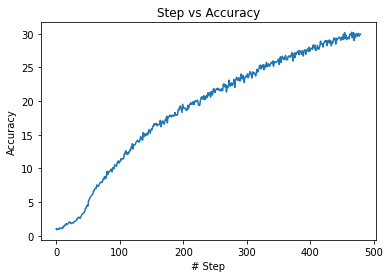

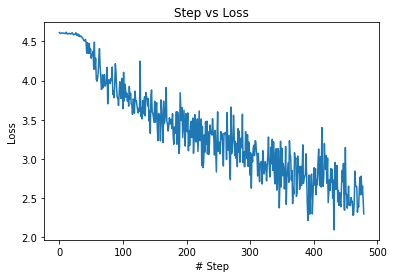

In [40]:
mtplt.plot(range(len(accuracy_list)), accuracy_list)
mtplt.xlabel("# Step")
mtplt.ylabel("Accuracy")
mtplt.title("Step vs Accuracy")
mtplt.show()

mtplt.plot(range(len(loss_list)), loss_list)
mtplt.xlabel("# Step")
mtplt.ylabel("Loss")
mtplt.title("Step vs Loss")
mtplt.show()

FC:

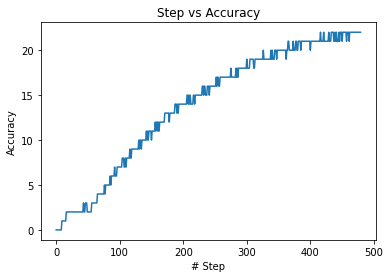

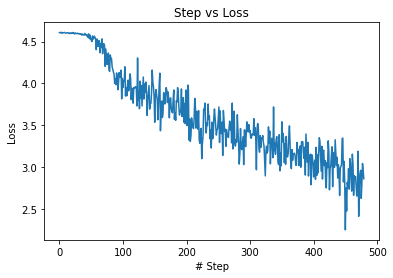

In [41]:
mtplt.plot(range(len(accuracy_list2)), accuracy_list2)
mtplt.xlabel("# Step")
mtplt.ylabel("Accuracy")
mtplt.title("Step vs Accuracy")
mtplt.show()

mtplt.plot(range(len(loss_list2)), loss_list2)
mtplt.xlabel("# Step")
mtplt.ylabel("Loss")
mtplt.title("Step vs Loss")
mtplt.show()